# Adult Income Classification Project

Ce notebook présente une étude complète du dataset Adult Income articulée en trois grandes parties :

1. **Exploration des données (EDA) et analyses non supervisées**
2. **Préprocessing des données et séparation des jeux d'apprentissage/test**
3. **Modélisation supervisée (baseline vs ensembles) et comparaison des performances**

Chaque section inclut des explications détaillées pour assurer la reproductibilité de l'analyse.


In [6]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_PATH = "adult.csv"


In [7]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [8]:
print("\nTypes de données:")
print(df.dtypes)

print("\nValeurs manquantes par colonne:")
print(df.isna().sum())



Types de données:
age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

Valeurs manquantes par colonne:
age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


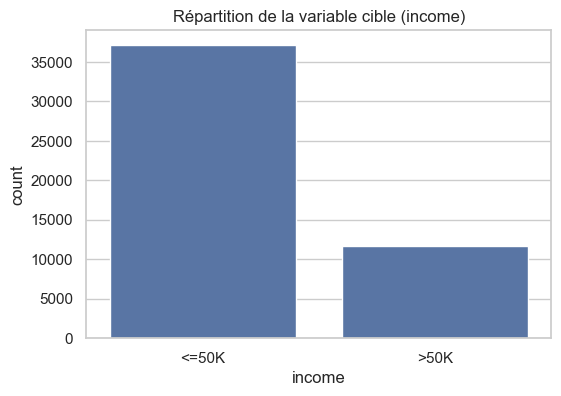

Répartition proportionnelle:
 income
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64


In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="income")
plt.title("Répartition de la variable cible (income)")
plt.show()

income_ratio = df["income"].value_counts(normalize=True)
print("Répartition proportionnelle:\n", income_ratio)


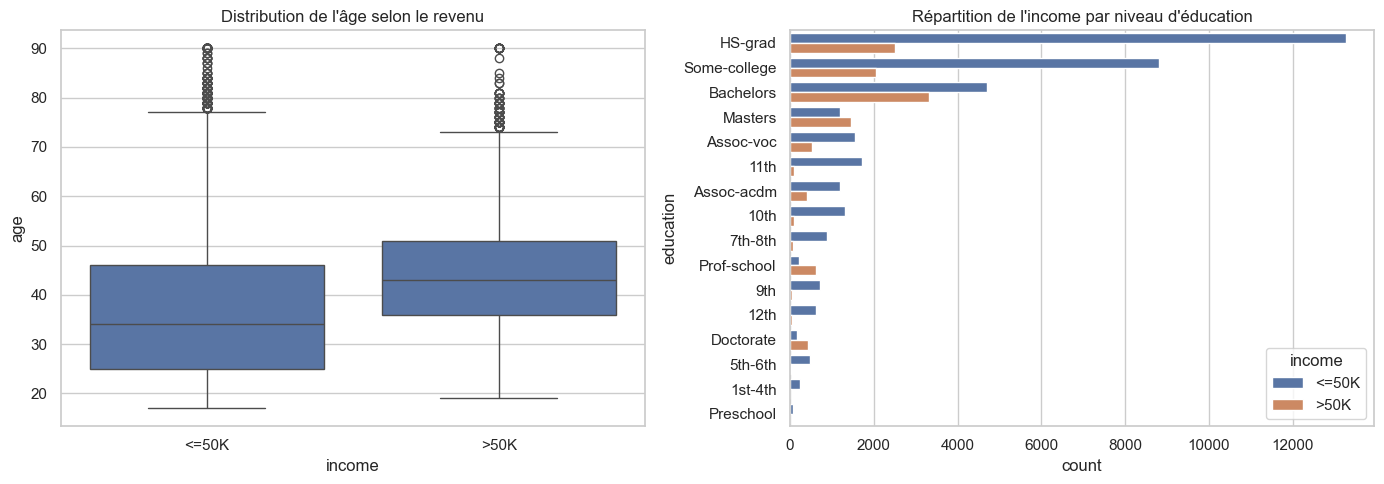

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df, x="income", y="age", ax=axes[0])
axes[0].set_title("Distribution de l'âge selon le revenu")

education_order = df["education"].value_counts().index
sns.countplot(data=df, y="education", hue="income", order=education_order, ax=axes[1])
axes[1].set_title("Répartition de l'income par niveau d'éducation")
plt.tight_layout()
plt.show()


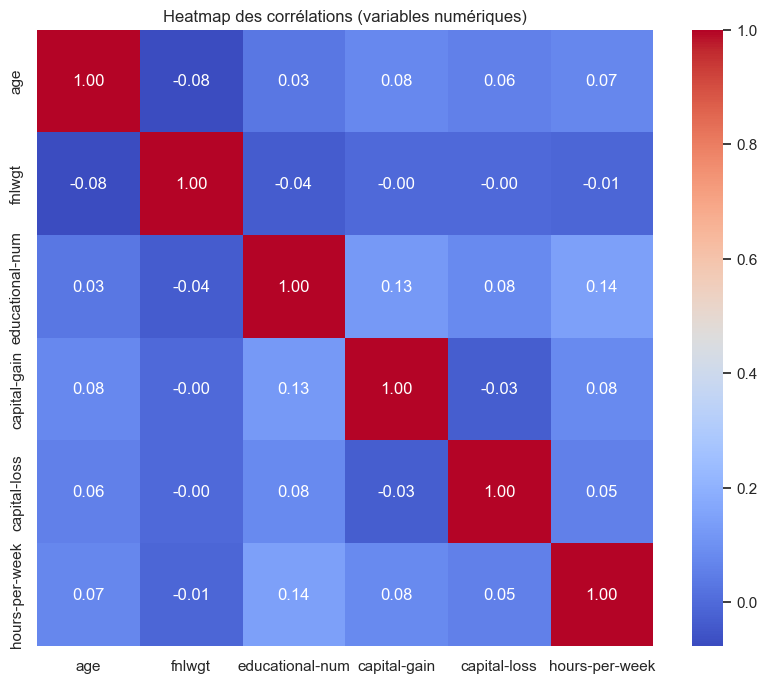

In [11]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Heatmap des corrélations (variables numériques)")
plt.show()


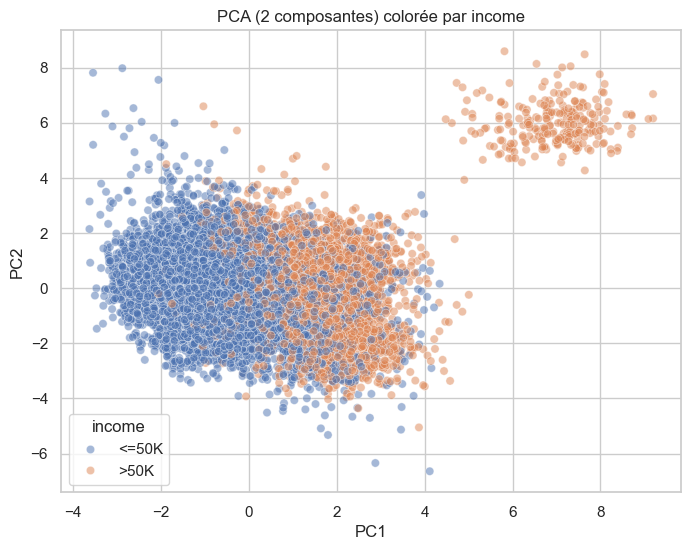

Variance expliquée par PC1+PC2: 39.10%


In [12]:
scaler = StandardScaler()
pca = PCA(n_components=2, random_state=42)

numeric_data = df[numeric_cols].copy()
numeric_scaled = scaler.fit_transform(numeric_data)
pca_components = pca.fit_transform(numeric_scaled)

pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
pca_df["income"] = df["income"].values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="income", alpha=0.5)
plt.title("PCA (2 composantes) colorée par income")
plt.show()

explained_var = pca.explained_variance_ratio_
print(f"Variance expliquée par PC1+PC2: {explained_var.sum():.2%}")


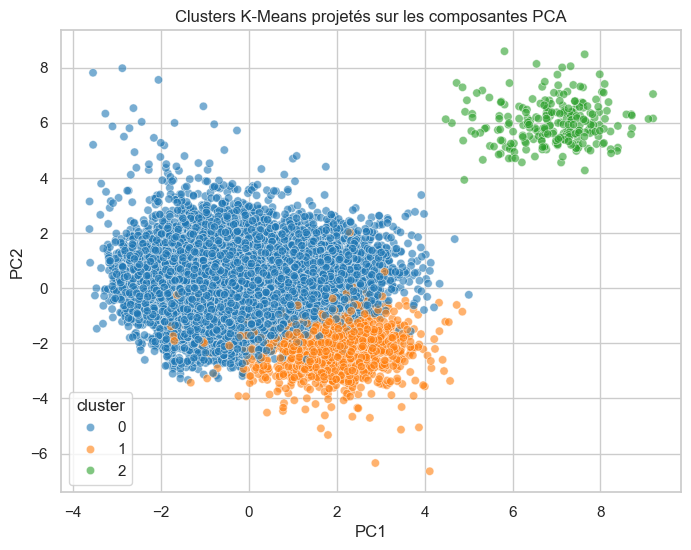

Distribution de income par cluster:
income     <=50K      >50K
row_0                     
0       0.777804  0.222196
1       0.489723  0.510277
2       0.000000  1.000000


In [13]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(numeric_scaled)

cluster_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
cluster_df["cluster"] = clusters.astype(str)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=cluster_df, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.6)
plt.title("Clusters K-Means projetés sur les composantes PCA")
plt.show()

cluster_target = pd.crosstab(clusters, df["income"], normalize="index")
print("Distribution de income par cluster:")
print(cluster_target)


## Partie 2 · Préparation des données & Découpage Train/Test

Nous encodons la cible, séparons features/cible, puis construisons un pipeline de prétraitement combinant imputations, standardisation des numériques et encodage one-hot des variables catégorielles.


In [14]:
target_col = "income"
label_encoder = LabelEncoder()
df["income_encoded"] = label_encoder.fit_transform(df[target_col])

y = df["income_encoded"]
X = df.drop(columns=[target_col, "income_encoded"])


In [15]:
numeric_features = [
    "age",
    "fnlwgt",
    "educational-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

categorical_features = [col for col in X.columns if col not in numeric_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print(f"Variables numériques ({len(numeric_features)}): {numeric_features}")
print(f"Variables catégorielles ({len(categorical_features)}): {categorical_features}")


Variables numériques (6): ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Variables catégorielles (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


## Partie 3 · Modélisation : Baseline vs Ensembles

Nous entraînons trois modèles (Logistic Regression, Random Forest, Gradient Boosting) encapsulés dans un pipeline complet, évaluons leurs performances via des rapports de classification, comparons Accuracy/F1, puis inspectons la matrice de confusion du meilleur modèle.


In [16]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

trained_pipelines = {}
metrics_records = []

for name, estimator in models.items():
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", estimator),
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics_records.append({"Model": name, "Accuracy": acc, "F1-Score": f1})
    trained_pipelines[name] = clf

    print(f"===== {name} =====")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

metrics_df = pd.DataFrame(metrics_records).sort_values(by="F1-Score", ascending=False)
metrics_df


===== Logistic Regression =====
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91      7431
        >50K       0.74      0.60      0.66      2338

    accuracy                           0.85      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.85      0.85      9769

===== Random Forest =====
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      7431
        >50K       0.74      0.63      0.68      2338

    accuracy                           0.86      9769
   macro avg       0.81      0.78      0.80      9769
weighted avg       0.85      0.86      0.86      9769

===== Gradient Boosting =====
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.92      7431
        >50K       0.80      0.61      0.69      2338

    accuracy                           0.87      9769
   macro avg       0.84      0.78      0

,Model,Accuracy,F1-Score
2,Gradient Boosting,0.869076,0.688732
1,Random Forest,0.858942,0.682342
0,Logistic Regression,0.854335,0.663036


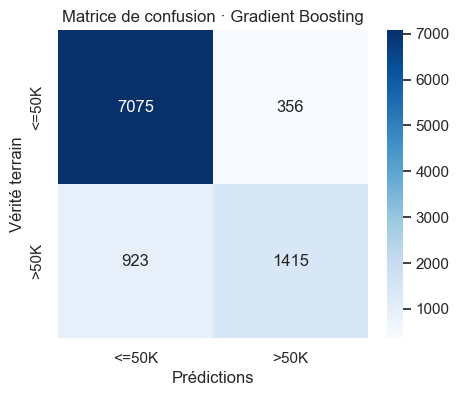

Meilleur modèle selon F1: Gradient Boosting


In [17]:
best_model_name = metrics_df.iloc[0]["Model"]
best_pipeline = trained_pipelines[best_model_name]
y_pred_best = best_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.title(f"Matrice de confusion · {best_model_name}")
plt.show()

print(f"Meilleur modèle selon F1: {best_model_name}")


### Conclusion

Les modèles d'ensemble (Random Forest et Gradient Boosting) surpassent la régression logistique sur l'Accuracy et le F1-Score, le meilleur selon F1 étant affiché dans la matrice de confusion. Cette configuration offre une base solide pour de futures itérations (optimisation d'hyperparamètres, gestion du déséquilibre, interprétabilité).
